In [1]:
from sklearn.datasets import fetch_20newsgroups

train_data = fetch_20newsgroups(subset="train")["data"]

from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders


tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer.decoder = decoders.WordPiece()
trainer = trainers.WordPieceTrainer(
    vocab_size=10000,  # 词汇表大小
    min_frequency=2,  # 最小出现频率
    special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],  # 特殊token
    continuing_subword_prefix="##",  # 子词前缀
)

tokenizer.train_from_iterator(train_data, trainer=trainer)
output = tokenizer.encode("This is a test sentence.")
print(tokenizer.decode(output.ids))

This is a test sentence.


In [2]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def skip_gram_dataset(train_data: list[str], tokenizer: Tokenizer, window_size: int = 12):

    context_dict: dict[int, set[int]] = {}
    corpus: list[list[int]] = [tokenizer.encode(text).ids for text in tqdm(train_data, desc="Tokenizing corpus")]
    for tokens in tqdm(corpus, desc="Scaning context"):
        length = len(tokens)
        if length < window_size:
            continue
        for i, token in enumerate(tokens):
            start = max(0, i - window_size)
            end = min(length, i + window_size + 1)
            context = tokens[start:i] + tokens[i + 1 : end]
            if token in context_dict:
                context_dict[token].update(context)
            else:
                context_dict[token] = set(context)
    center_list = []
    context_list = []
    for center_token, context_tokens in context_dict.items():
        for context_token in context_tokens:
            center_list.append(center_token)
            context_list.append(context_token)

    return TensorDataset(
        torch.tensor(center_list, dtype=torch.long, device=DEVICE),
        torch.tensor(context_list, dtype=torch.long, device=DEVICE),
    )


# 创建数据集
dataset = skip_gram_dataset(train_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

Scaning context: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11314/11314 [00:12<00:00, 902.22it/s]


In [9]:
class SkipGramModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.linear(x)
        return x

In [10]:
num_epochs = 10

vocab = tokenizer.get_vocab()

model = SkipGramModel(len(vocab), 200).to(DEVICE) if True else torch.load("SkipGram.pth", weights_only=False)

optimizer = torch.optim.Adam(model.parameters())
lossi = []
for epoch in range(num_epochs):
    total_loss = 0
    for center_token, context_token in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        logits = model(center_token)
        loss = torch.nn.functional.cross_entropy(logits, context_token)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        total_loss += loss
        lossi.append(loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:21<00:00, 105.86it/s]


Epoch 1, Loss: 8.9488


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:22<00:00, 105.55it/s]


Epoch 2, Loss: 8.8091


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:23<00:00, 104.58it/s]


Epoch 3, Loss: 8.7644


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:20<00:00, 106.73it/s]


Epoch 4, Loss: 8.7309


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:22<00:00, 105.36it/s]


Epoch 5, Loss: 8.7031


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:22<00:00, 105.49it/s]


Epoch 6, Loss: 8.6799


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:22<00:00, 105.00it/s]


Epoch 7, Loss: 8.6608


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:20<00:00, 106.83it/s]


Epoch 8, Loss: 8.6456


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [02:37<00:00, 95.32it/s]


Epoch 9, Loss: 8.6333


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14999/14999 [03:00<00:00, 83.12it/s]

Epoch 10, Loss: 8.6237


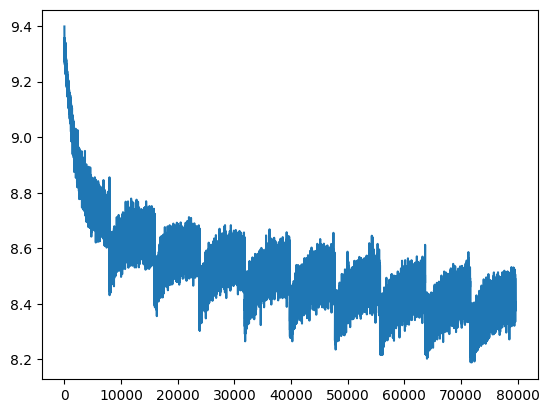

In [6]:
import matplotlib.pyplot as plt

plt.plot(lossi)
plt.show()

In [11]:
import numpy as np

word_vectors = model.embedding.weight.data.cpu().numpy()


def find_similar_words(query_word: str | list[str], word_vectors, vocab, top_k=5):
    if query_word not in vocab:
        print(f"'{query_word}' not in vocabulary")
        return

    # 获取查询词的向量
    query_idx = vocab[query_word]
    query_vec = word_vectors[query_idx]

    # 计算余弦相似度
    norms = np.linalg.norm(word_vectors, axis=1)
    dot_products = np.dot(word_vectors, query_vec)
    cosine_similarities = dot_products / (norms * np.linalg.norm(query_vec))

    # 获取最相似的词（排除自己）
    similar_indices = np.argsort(-cosine_similarities)[1 : top_k + 1]

    # 打印结果
    print(f"和 {query_word} 最相关的词:")
    for idx in similar_indices:
        word = list(vocab.keys())[list(vocab.values()).index(idx)]
        print(f"{word}: {cosine_similarities[idx]:.3f}")

In [13]:
find_similar_words("Jesus", word_vectors, vocab, 10)

和 Jesus 最相关的词:
God: 0.682
Christ: 0.669
Christians: 0.665
Bible: 0.633
faith: 0.625
Christian: 0.580
Scripture: 0.575
Lord: 0.560
Him: 0.544
church: 0.541


In [26]:
find_similar_words("arms", word_vectors, vocab, 10)

和 arms 最相关的词:
bear: 0.527
armed: 0.464
militia: 0.457
arm: 0.447
military: 0.447
Milit: 0.419
killed: 0.414
soldiers: 0.414
weapon: 0.406
villages: 0.404
